In [1]:
import os
import subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lidar

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
class Record(object):
    def __init__(self, lidar_record, bicycle_record):
        self.lidar = lidar_record
        self.bicycle = bicycle_record
        self.__sync = None

lidar_records = lidar.get_lidar_records()
bicycle_records = lidar.get_bicycle_records()
records = [Record(l, b)
           for l, b in zip(lidar_records, bicycle_records)]

In [3]:
# If we try to plot all the data, jupyter will crash
def reduced_signal(time, signal, tol=1e-6):
    """Return time and signal arrays with the runs
    reduced to 2 subsequent elements.
    > reduced_signal([0, 1, 2, 3, 4], [0, 0, 0, 1, 2])
    > [0, 2, 3, 4], [0, 0, 1, 2]
    """
    time = np.asarray(time)
    signal = np.asarray(signal)
    event = np.where(np.abs(np.diff(signal)) > tol)[0] + 1
    
    index = [0] # include first element
    
    for i in event:
        skip = i - index[-1]
        
        # If we skip more than one index include 
        # previous index so that edges are preserved
        assert skip > 0
        if skip > 1:
            index.append(i - 1)
        index.append(i)
        
    # add last element if the signal ends in a run
    if index[-1] != len(time) - 1:
        index.append(len(time) - 1)
    
    return time[index], signal[index]


a = np.array([0, 0, 0, 1, 1, 2, 3, 0, 0])
t = np.arange(len(a)) + 1
print(t)
print(a)

print(*reduced_signal(t, a))

[1 2 3 4 5 6 7 8 9]
[0 0 0 1 1 2 3 0 0]
[1 3 4 5 6 7 8 9] [0 0 1 1 2 3 0 0]


In [4]:
def nearest_millisecond(t):
    return np.round(t*1000)/1000
    
lidar = records[0].lidar
bicycle = records[0].bicycle
print('length of lidar signal: {}'.format(len(lidar.time)))
print('length of bicycle signal: {}'.format(len(bicycle.time)))

# convert time to the nearest millisecond
lidar_dt = nearest_millisecond(np.diff(lidar.time))
bicycle_dt = nearest_millisecond(np.diff(bicycle.time))

reduced_lidar_dt = reduced_signal(lidar.time[1:], lidar_dt)
reduced_bicycle_dt = reduced_signal(bicycle.time[1:], bicycle_dt)
print('length of reduced lidar signal: {} ({:0.2f}%)'.format(
   len(reduced_lidar_dt[0]), len(reduced_lidar_dt[0])/len(lidar.time)*100
))
print('length of reduced bicycle signal: {} ({:0.2f}%)'.format(
   len(reduced_bicycle_dt[0]), len(reduced_bicycle_dt[0])/len(bicycle.time)*100
))

length of lidar signal: 28356
length of bicycle signal: 172099
length of reduced lidar signal: 1036 (3.65%)
length of reduced bicycle signal: 3875 (2.25%)


In [5]:
def plot_record_timeseries(record):
    lidar = record.lidar
    bicycle = record.bicycle
    
    # convert time to the nearest millisecon
    sig_dt = lambda x: nearest_millisecond(np.diff(x.time))
    lidar_dt = sig_dt(lidar)
    bicycle_dt = sig_dt(bicycle)
    
    colors = sns.color_palette('Paired', 10)
    
    def plot_two(axis, x1, y1, x2, y2, color_index, label):
        l1 = axis.plot(x1, y1,
                       color=colors[color_index],
                       label='lidar {}'.format(label))
        l2 = axis.plot(x2, y2,
                       color=colors[color_index + 1],
                       label='bicycle {}'.format(label))
    
    
    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    plot_two(
        ax[0],
        *reduced_signal(lidar.time[1:], lidar_dt),
        *reduced_signal(bicycle.time[1:], bicycle_dt),
        0, 'sample time'
    )
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('sample time [s]')
    ax[0].legend()
    
    plot_two(
        ax[1],
        *reduced_signal(lidar.time, lidar.sync),
        *reduced_signal(bicycle.time, bicycle.sync),
        2, 'sync'
    )
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('button status')
    ax[1].legend()
    
    plt.show()
    return fig, ax

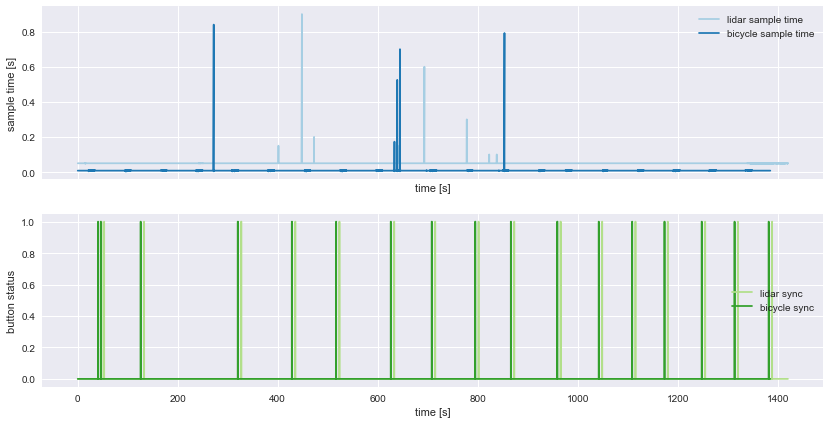

(<matplotlib.figure.Figure at 0x1194b7b70>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1194b75f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e4c2198>], dtype=object))

In [6]:
plot_record_timeseries(records[0])

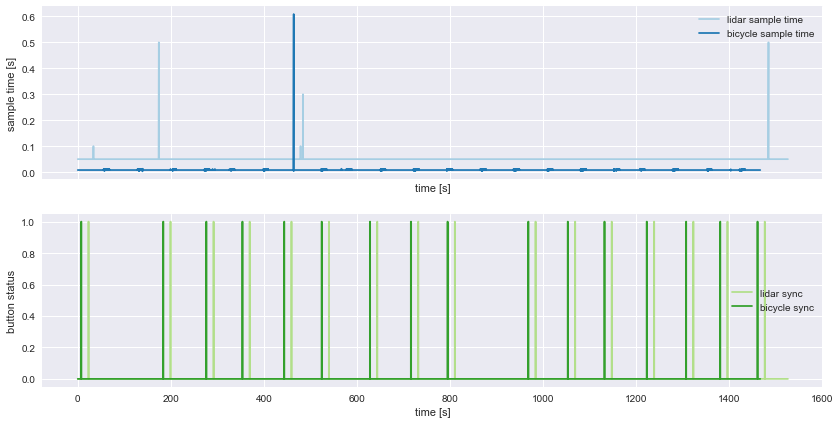

(<matplotlib.figure.Figure at 0x119686160>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11967cbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12134dcc0>], dtype=object))

In [7]:
plot_record_timeseries(records[1])

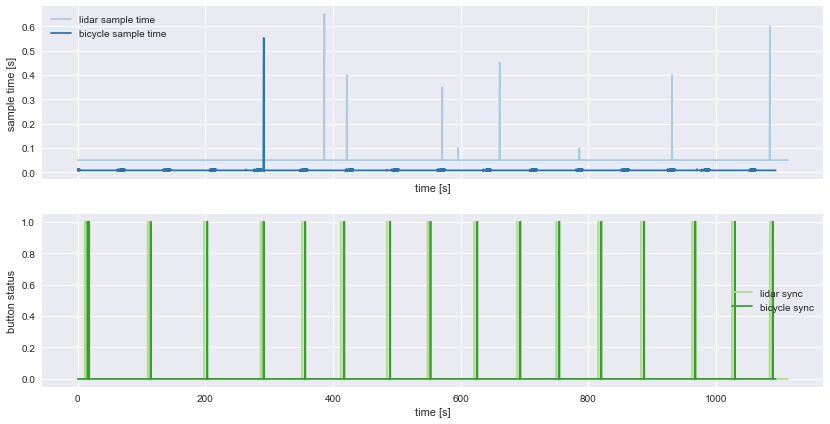

(<matplotlib.figure.Figure at 0x122156eb8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11989a7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e5199e8>], dtype=object))

In [8]:
plot_record_timeseries(records[2])

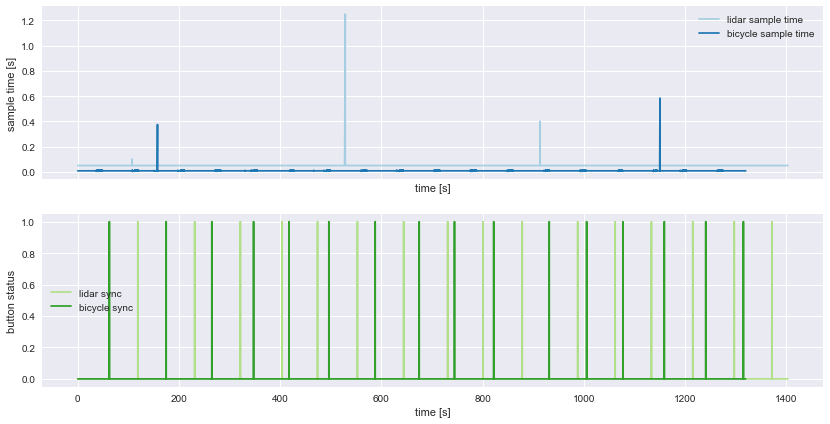

(<matplotlib.figure.Figure at 0x10ee4f9b0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f5fd748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120685358>], dtype=object))

In [9]:
plot_record_timeseries(records[3])

In [10]:
"""TODO
 - maximize autocorrelation of sync signal
 - determine bounds on time sync error
 - determine bounds on distance error (bicycle to obstacle) corresponding to time sync error
"""

'TODO\n - maximize autocorrelation of sync signal\n - determine bounds on time sync error\n - determine bounds on distance error (bicycle to obstacle) corresponding to time sync error\n'

In [11]:
import numpy.testing as npt

class TimeSignal(object):
    def __init__(self, t, y):
        assert(isinstance(t, np.ndarray))
        assert(isinstance(y, np.ndarray))
        assert(t.shape == y.shape)
        self.time = t
        self.signal = y
        self.time.flags.writeable = False
        self.signal.flags.writeable = False
        self.__mutable = False
        
    def shift_time(self, shift):
        if self.__mutable:
            self.time.flags.writeable = True
            self.time += shift
            self.time.flags.writeable = False
            return True
        return False

class SampledTimeSignal(TimeSignal):
    def __init__(self, t, y, p=None):
        super(SampledTimeSignal, self).__init__(t, y)
        self.period = np.diff(t).mean()
        if p is not None:
            npt.assert_almost_equal(self.period, p)
        
        # allow methods to modify time and signal data
        self.__mutable = True
        
    def shift_time_index(self, shift):
        return self.shift_time(shift * self.period)
        
    def __getitem__(self, key):
        period = self.period
        if key.step is not None:
            period *= key.step
        
        signal_slice = SampledTimeSignal(self.time[key], self.signal[key], period)
        signal_slice.__mutable = False
        return signal_slice
        
def interpolated_sync(record, period=0.008):
    """Return a pair of interpolated, evenly sampled sync signals.
    
    Parameters
    record: Record object
    period: float, period for interpolated x-coordinates 'x1p' and 'x2p'
    
    Returns
    s_lidar: SampledTimeSignal, interpolated values of sync signal for LIDAR record
    s_bicycle: SampledTimeSignal, interpolated values of sync signal for bicycle record
    """
    lidar_t = np.arange(0, record.lidar.time.max(), period)
    lidar_sync = np.interp(lidar_t, record.lidar.time, record.lidar.sync)
    
    bicycle_t = np.arange(0, record.bicycle.time.max(), period)
    bicycle_sync = np.interp(bicycle_t, record.bicycle.time, record.bicycle.sync)
    return (SampledTimeSignal(lidar_t, lidar_sync, period),
            SampledTimeSignal(bicycle_t, bicycle_sync, period))

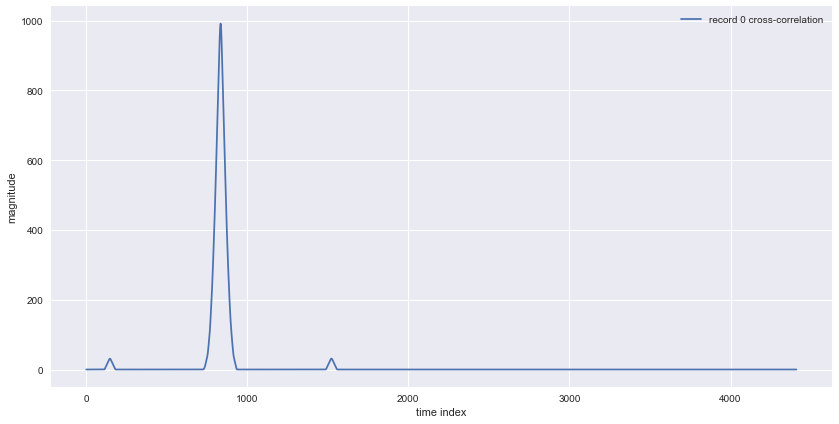

time offset: 6.672 [s]
time index offset: 834.0


In [12]:
def time_offset(s1, s2):
    """Returns time offset of signal 2 that maximizes cross-correlation.
    
    This uses np.correlate mode='valid' to compute cross-correlation.
    """
    assert(isinstance(s1, SampledTimeSignal))
    assert(isinstance(s2, SampledTimeSignal))
    
    # Period must be the same to compute cross-correlation
    npt.assert_almost_equal(s1.period, s2.period)
    
    # Inputs to np.correlate will get swapped 
    # if s1 is not longer than s2.
    assert(s1.signal.shape[0] > s2.signal.shape[0])
    
    corr = lambda m: np.correlate(s1.signal, s2.signal, mode=m)
    
    # try 'valid' mode first
    c = corr('valid')
    
    # A correctly synchronized cross-correlation value is around 900-1000
    if c.max() < 100:
        # prepend 10 minutes of data to signal 1 so we can use valid mode
        start = s1.time[0] + s1.period
        stop = start + 10*60*s1.period
        pre_t = -np.arange(start, stop, s1.period)[::-1] 
        pre_y = np.zeros(pre_t.shape)
        s1.time = np.concatenate((pre_t, s1.time))
        s1.signal = np.concatenate((pre_y, s1.signal))
        c = corr('valid')
        
    # assume we can sync now
    assert(c.max() > 100)
    
    current_time_offset = s2.time[0] - s1.time[0]
    return s1.period*c.argmax() - current_time_offset


s1, s2 = interpolated_sync(records[0])
c = np.correlate(s1.signal, s2.signal, mode='valid')
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(c, label='record 0 cross-correlation')
ax.set_ylabel('magnitude')
ax.set_xlabel('time index')
ax.legend()
plt.show()

p = time_offset(s1, s2)
print('time offset: {} [s]'.format(p))
print('time index offset: {}'.format(p/s1.period))

In [13]:
def sync_record(record):
    assert(isinstance(record, Record))
    
    # Calculate interpolated/resampled signals for synchronization
    # Both signals must be periodic with the same period to
    # calculate cross-correlation
    p = nearest_millisecond(np.diff(record.bicycle.time)).mean()
    try:
        a, b = record.__sync
    except AttributeError:
        a, b = interpolated_sync(record, period=p)
        record.__sync = a, b
    offset = time_offset(a, b)
    record.bicycle.time += offset - (record.bicycle.time[0] - record.lidar.time[0])
    return offset

for r in records:
    offset = sync_record(r)
    print('applying time offset of {}'.format(offset))

applying time offset of 6.669394548454953
applying time offset of 15.594938042633327
applying time offset of -4.433863487095852
applying time offset of 56.312648174862616


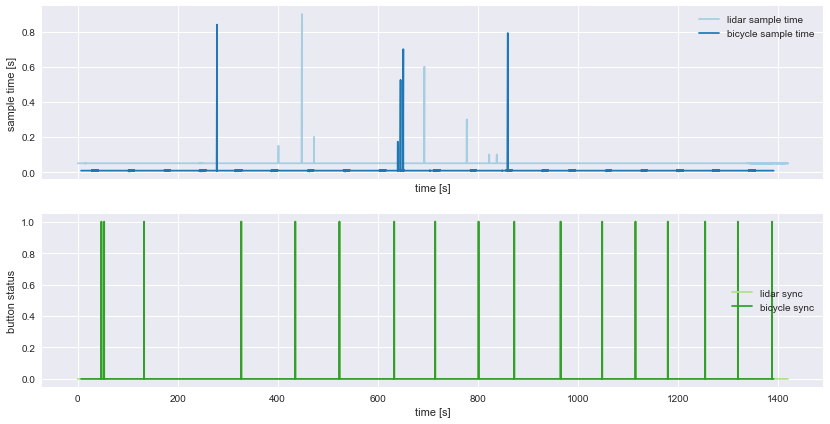

(<matplotlib.figure.Figure at 0x12068e940>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d6bdba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ec478d0>], dtype=object))

In [14]:
plot_record_timeseries(records[0])

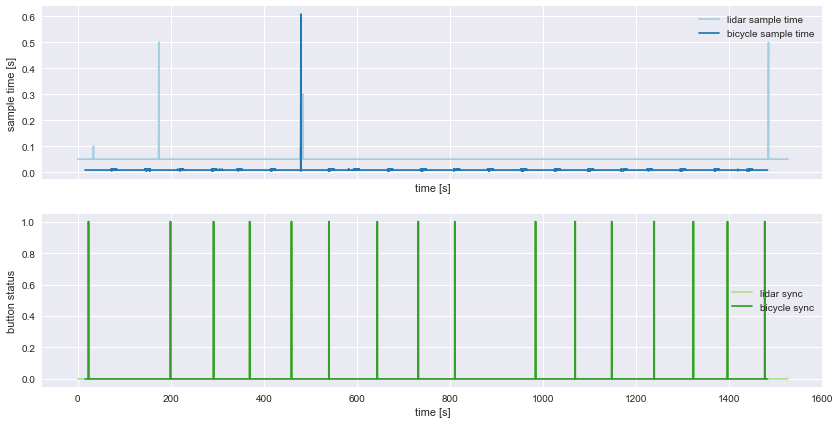

(<matplotlib.figure.Figure at 0x123273940>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11956deb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1238047b8>], dtype=object))

In [15]:
plot_record_timeseries(records[1])

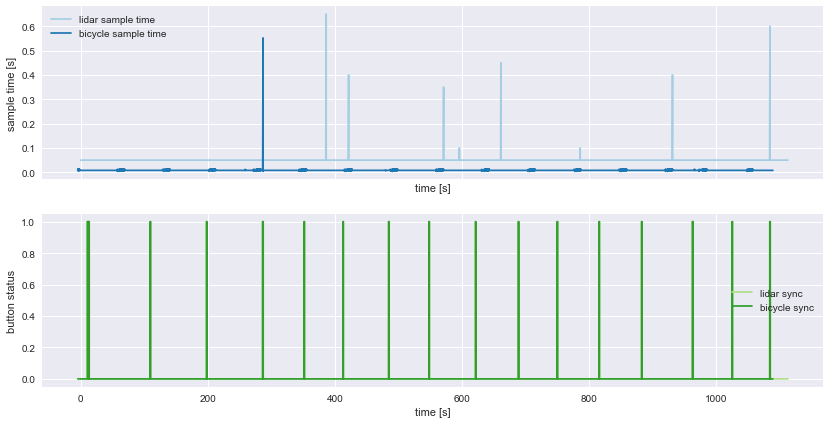

(<matplotlib.figure.Figure at 0x11d6b6fd0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f552550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f61fc18>], dtype=object))

In [16]:
plot_record_timeseries(records[2])

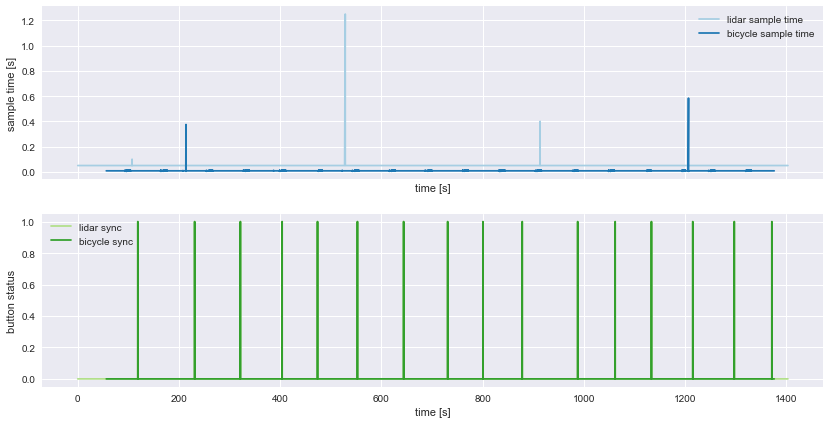

(<matplotlib.figure.Figure at 0x12068e630>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11489f780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1194dc588>], dtype=object))

In [17]:
plot_record_timeseries(records[3])